In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\New\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading in data
# ==============================================================================
solar5=pd.read_csv('Solar 5.csv')

In [3]:
#Converting to Datetime objects
# ==============================================================================
solar5['datetime']=pd.to_datetime(solar5['datetime'], format='%Y-%m-%d %H:%M:%S')
solar5= solar5.set_index('datetime')
solar5= solar5.asfreq('H')

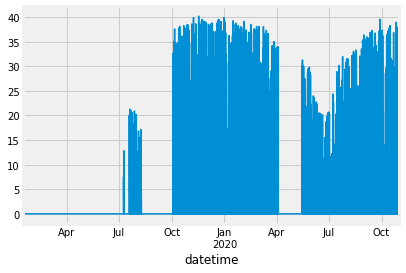

In [4]:
solar5['series_value'].plot()

In [5]:
#Split Train-Val for Solar5
# ==============================================================================
start_train='2019-10-01 00:00'
end_train='2020-04-01 00:00'
start_val='2020-06-01 01:00'
end_val='2020-08-01 00:00'
start_test='2020-08-01 01:00'

solar5train=solar5.loc[start_train:end_train, :]
solar5val=solar5.loc[start_val:end_val, :]
solar5test=solar5.loc[start_test:, :]

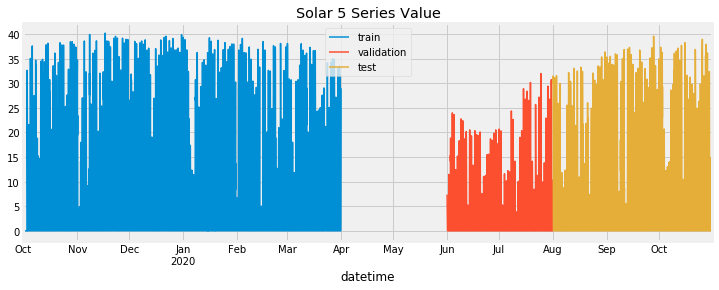

In [6]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar5train['series_value'].plot(ax=ax, label='train')
solar5val['series_value'].plot(ax=ax, label='validation')
solar5test['series_value'].plot(ax=ax, label='test')
ax.set_title('Solar 5 Series Value')
ax.legend();

In [7]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-23 18:18:46 
Last fit date: None 
Skforecast version: 0.4.3 

In [8]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = solar5.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar5train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:14,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:13,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:04<00:12,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:11,  1.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:09,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:08<00:08,  1.38s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:09<00:06,  1.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:13<00:02,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:14,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:12,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:11,  1.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:10,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:08,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:07,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:13,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:13,  1.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:04<00:12,  1.34s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:10,  1.29s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:08,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:07,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:04,  1.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:14,  1.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:13,  1.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:04<00:11,  1.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:10,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:08,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:07,  1.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.31s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [01:02<00:00, 15.51s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 125.08479730398156



In [9]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
47,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",125.084797,0.10,10.0,500.0
36,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",125.084797,0.01,3.0,100.0
37,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",125.084797,0.01,3.0,500.0
38,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",125.084797,0.01,5.0,100.0
39,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",125.084797,0.01,5.0,500.0
40,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",125.084797,0.01,10.0,100.0
46,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",125.084797,0.10,10.0,100.0
42,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",125.084797,0.10,3.0,100.0
43,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",125.084797,0.10,3.0,500.0
44,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",125.084797,0.10,5.0,100.0


In [10]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = solar5['series_value'],
    initial_train_size = len(solar5.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False 
    )

print(f"Backtest error: {metric}")

Backtest error: 41.40569469547968


In [11]:
# Predictions
# ==============================================================================
predictions

,pred
2020-08-01 01:00:00,19.656707
2020-08-01 02:00:00,21.137383
2020-08-01 03:00:00,22.506348
2020-08-01 04:00:00,26.983364
2020-08-01 05:00:00,14.241476
...,...
2020-10-31 19:00:00,0.607610
2020-10-31 20:00:00,3.474722
2020-10-31 21:00:00,10.070834
2020-10-31 22:00:00,16.523498


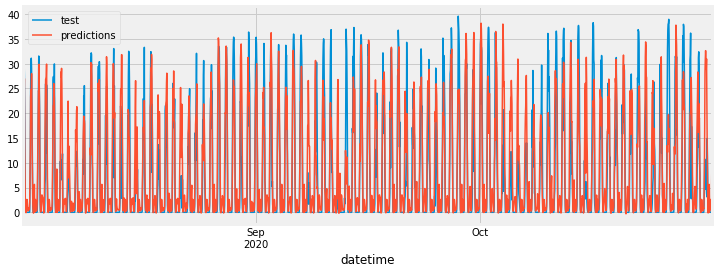

In [12]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar5test['series_value'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [13]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [14]:
solar5test=solar5test.dropna()
solar5train=solar5train.dropna()

In [15]:
mean_absolute_scaled_error(solar5test.reset_index()['series_value'],predictions.reset_index()['pred'],solar5train.reset_index()['series_value'])

1.3012079782044488